In [1]:
import casestudy_tools as tools
df = tools.preprocess()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22223 entries, 0 to 22222
Data columns (total 37 columns):
AGE                    22223 non-null float64
BILL                   22223 non-null float64
ORGYN                  22223 non-null int64
AFFL                   22223 non-null int32
LTIME                  22223 non-null float64
GENDER_F               22223 non-null uint8
GENDER_M               22223 non-null uint8
GENDER_U               22223 non-null uint8
TV_REG_Border          22223 non-null uint8
TV_REG_C Scotland      22223 non-null uint8
TV_REG_East            22223 non-null uint8
TV_REG_London          22223 non-null uint8
TV_REG_Midlands        22223 non-null uint8
TV_REG_N East          22223 non-null uint8
TV_REG_N Scot          22223 non-null uint8
TV_REG_N West          22223 non-null uint8
TV_REG_S & S East      22223 non-null uint8
TV_REG_S West          22223 non-null uint8
TV_REG_Ulster          22223 non-null uint8
TV_REG_Wales & West    22223 non-null uint8
TV_RE

<h1>Data PreProcessing</h1>

In [2]:
import pandas as pd
df = pd.read_csv("datasets/organics.csv")
#df.dtypes

In [3]:
df = df.drop(['CUSTID', 'LCDATE', 'ORGANICS', 'AGEGRP1', 'AGEGRP2'], axis = 1)
df = df.drop(['NEIGHBORHOOD'], axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22223 entries, 0 to 22222
Data columns (total 12 columns):
GENDER    19711 non-null object
DOB       22223 non-null object
EDATE     22223 non-null object
AGE       20715 non-null float64
TV_REG    21758 non-null object
NGROUP    21549 non-null object
BILL      22223 non-null float64
REGION    21758 non-null object
CLASS     22223 non-null object
ORGYN     22223 non-null int64
AFFL      21138 non-null float64
LTIME     21942 non-null float64
dtypes: float64(4), int64(1), object(7)
memory usage: 2.0+ MB


In [4]:
# Calculates the years between DOB and EDATE and adds that value to age for missing values.
from datetime import datetime
import numpy as np
dateformat = '%Y-%m-%d'
edate = pd.Timestamp(df['EDATE'][0])
df['DOB'] = pd.to_datetime(df['DOB'], format=dateformat)    # 1
df['DOB'] = df['DOB'].where(df['DOB'] < edate, df['DOB'] -  np.timedelta64(100, 'Y'))   # 2
df['AGE'] = (edate - df['DOB']).astype('<m8[Y]')    # 3

df['AGE']
df = df.drop(['EDATE', 'DOB'], axis = 1)
#df.info()

In [5]:
# denote errorneous values in AFFL column. Should be on scale 1-30.
mask = df['AFFL'] < 1
df.loc[mask, 'AFFL'] = 1
mask = df['AFFL'] > 30
df.loc[mask, 'AFFL'] = 30

# Fill mean values for AFFL column.
df['AFFL'].fillna(df['AFFL'].mean(), inplace=True)
# Convert the scale to integer. Not sure if this is necessary.
df['AFFL'] = df['AFFL'].astype(int)
#df.info()
#df['AFFL'].value_counts(bins=8)
#sorted(df['AFFL'].unique())

In [6]:
# Fills mean values based on age for loyalty time. 
means = df.groupby(['AGE'])['LTIME'].mean()
df = df.set_index(['AGE'])
df['LTIME'] = df['LTIME'].fillna(means)
df = df.reset_index()


In [7]:
df['GENDER'].fillna('U', inplace=True)
#df['GENDER'].unique()

In [8]:
df = pd.get_dummies(df)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22223 entries, 0 to 22222
Data columns (total 37 columns):
AGE                    22223 non-null float64
BILL                   22223 non-null float64
ORGYN                  22223 non-null int64
AFFL                   22223 non-null int32
LTIME                  22223 non-null float64
GENDER_F               22223 non-null uint8
GENDER_M               22223 non-null uint8
GENDER_U               22223 non-null uint8
TV_REG_Border          22223 non-null uint8
TV_REG_C Scotland      22223 non-null uint8
TV_REG_East            22223 non-null uint8
TV_REG_London          22223 non-null uint8
TV_REG_Midlands        22223 non-null uint8
TV_REG_N East          22223 non-null uint8
TV_REG_N Scot          22223 non-null uint8
TV_REG_N West          22223 non-null uint8
TV_REG_S & S East      22223 non-null uint8
TV_REG_S West          22223 non-null uint8
TV_REG_Ulster          22223 non-null uint8
TV_REG_Wales & West    22223 non-null uint8
TV_RE

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

rs = 10

y = df['ORGYN']
X = df.drop(['ORGYN'], axis=1)
X_mat = X.as_matrix()
X_train, X_test, y_train, y_test = train_test_split(X_mat, y, test_size=0.3, stratify=y, random_state=rs)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train, y_train)
X_test = scaler.transform(X_test)

In [11]:
from sklearn.neural_network import MLPClassifier

In [12]:
model = MLPClassifier(random_state=rs)
model.fit(X_train, y_train)

print("Train accuracy:", model.score(X_train, y_train))
print("Test accuracy:", model.score(X_test, y_test))

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

print(model)

Train accuracy: 0.825404988429
Test accuracy: 0.812809359532
             precision    recall  f1-score   support

          0       0.84      0.93      0.88      5015
          1       0.69      0.45      0.54      1652

avg / total       0.80      0.81      0.80      6667

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=10, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)


In [13]:
model = MLPClassifier(max_iter=100, random_state=rs)
model.fit(X_train, y_train)

print("Train accuracy:", model.score(X_train, y_train))
print("Test accuracy:", model.score(X_test, y_test))

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

print(model)

Train accuracy: 0.825404988429
Test accuracy: 0.812809359532
             precision    recall  f1-score   support

          0       0.84      0.93      0.88      5015
          1       0.69      0.45      0.54      1652

avg / total       0.80      0.81      0.80      6667

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=100, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=10, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)


In [14]:
model = MLPClassifier(max_iter=80, random_state=rs)
model.fit(X_train, y_train)

print("Train accuracy:", model.score(X_train, y_train))
print("Test accuracy:", model.score(X_test, y_test))

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

print(model)

Train accuracy: 0.825404988429
Test accuracy: 0.812809359532
             precision    recall  f1-score   support

          0       0.84      0.93      0.88      5015
          1       0.69      0.45      0.54      1652

avg / total       0.80      0.81      0.80      6667

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=80, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=10, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)


In [15]:
print(X_train.shape)

(15556, 36)


In [16]:
params = {'hidden_layer_sizes': [(x,) for x in range(5, 36, 15)]}

cv = GridSearchCV(param_grid=params, estimator=MLPClassifier(random_state=rs), cv=3, n_jobs=-1)
cv.fit(X_train, y_train)

print("Train accuracy:", cv.score(X_train, y_train))
print("Test accuracy:", cv.score(X_test, y_test))

y_pred = cv.predict(X_test)
print(classification_report(y_test, y_pred))

print(cv.best_params_)

Train accuracy: 0.813962458215
Test accuracy: 0.817159142043
             precision    recall  f1-score   support

          0       0.83      0.95      0.89      5015
          1       0.72      0.42      0.53      1652

avg / total       0.81      0.82      0.80      6667

{'hidden_layer_sizes': (5,)}


In [17]:
# new parameters
params = {'hidden_layer_sizes': [(3,), (5,), (7,), (9,)]}

cv = GridSearchCV(param_grid=params, estimator=MLPClassifier(random_state=rs), cv=10, n_jobs=-1)
cv.fit(X_train, y_train)

print("Train accuracy:", cv.score(X_train, y_train))
print("Test accuracy:", cv.score(X_test, y_test))

y_pred = cv.predict(X_test)
print(classification_report(y_test, y_pred))

print(cv.best_params_)

Train accuracy: 0.814412445359
Test accuracy: 0.818959052047
             precision    recall  f1-score   support

          0       0.84      0.94      0.89      5015
          1       0.72      0.44      0.55      1652

avg / total       0.81      0.82      0.80      6667

{'hidden_layer_sizes': (3,)}


In [37]:
params = {'hidden_layer_sizes': [(3,)], 'alpha': [0.0001]}

cv = GridSearchCV(param_grid=params, estimator=MLPClassifier(random_state=rs), cv=10, n_jobs=-1)
cv.fit(X_train, y_train)

print("Train accuracy:", cv.score(X_train, y_train))
print("Test accuracy:", cv.score(X_test, y_test))

y_pred = cv.predict(X_test)
print(classification_report(y_test, y_pred))

print(cv.best_params_)

Train accuracy: 0.814412445359
Test accuracy: 0.818959052047
             precision    recall  f1-score   support

          0       0.84      0.94      0.89      5015
          1       0.72      0.44      0.55      1652

avg / total       0.81      0.82      0.80      6667

{'alpha': 0.0001, 'hidden_layer_sizes': (3,)}


In [45]:
print(cv)
# print(cv.best_estimator_)

GridSearchCV(cv=10, error_score='raise',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=10, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'hidden_layer_sizes': [(3,)], 'alpha': [0.0001]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)


In [53]:
model = MLPClassifier(max_iter=40, random_state=rs, hidden_layer_sizes=(3,))
model.fit(X_train, y_train)

print("Train accuracy:", model.score(X_train, y_train))
print("Test accuracy:", model.score(X_test, y_test))

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

print(model)

Train accuracy: 0.814412445359
Test accuracy: 0.818959052047
             precision    recall  f1-score   support

          0       0.84      0.94      0.89      5015
          1       0.72      0.44      0.55      1652

avg / total       0.81      0.82      0.80      6667

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(3,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=40, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=10, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)


In [20]:
params = {'hidden_layer_sizes': [(3,), (5,), (7,), (9,)], 'alpha': [0.01,0.001, 0.0001, 0.00001]}

cv = GridSearchCV(param_grid=params, estimator=MLPClassifier(random_state=rs), cv=10, n_jobs=-1)
cv.fit(X_train_log, y_train_log)

print("Train accuracy:", cv.score(X_train_log, y_train_log))
print("Test accuracy:", cv.score(X_test_log, y_test_log))

y_pred = cv.predict(X_test_log)
print(classification_report(y_test_log, y_pred))

print(cv.best_params_)


Train accuracy: 0.813641038827
Test accuracy: 0.815359232038
             precision    recall  f1-score   support

          0       0.83      0.94      0.88      5015
          1       0.72      0.42      0.53      1652

avg / total       0.80      0.82      0.80      6667

{'alpha': 0.0001, 'hidden_layer_sizes': (7,)}


In [21]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

rfe = RFECV(estimator = LogisticRegression(random_state=rs), cv=10)
rfe.fit(X_train_log, y_train_log)

print(rfe.n_features_)

7


In [22]:
# transform log 
X_train_rfe = rfe.transform(X_train_log)
X_test_rfe = rfe.transform(X_test_log)

# step = int((X_train_rfe.shape[1] + 5)/5);
params = {'hidden_layer_sizes': [(3,), (5,), (7,), (9,)], 'alpha': [0.01,0.001, 0.0001, 0.00001]}

cv = GridSearchCV(param_grid=params, estimator=MLPClassifier(random_state=rs), cv=10, n_jobs=-1)
cv.fit(X_train_rfe, y_train_log)

print("Train accuracy:", cv.score(X_train_rfe, y_train_log))
print("Test accuracy:", cv.score(X_test_rfe, y_test_log))

y_pred = cv.predict(X_test_rfe)
print(classification_report(y_test_log, y_pred))

print(cv.best_params_)

Train accuracy: 0.812612496786
Test accuracy: 0.819559022049
             precision    recall  f1-score   support

          0       0.83      0.95      0.89      5015
          1       0.73      0.43      0.54      1652

avg / total       0.81      0.82      0.80      6667

{'alpha': 0.001, 'hidden_layer_sizes': (9,)}


In [55]:
from sklearn.tree import DecisionTreeClassifier

params = {'criterion': ['gini', 'entropy'],
          'max_depth': (2, 5),
          'min_samples_leaf': range(1,2)}

cv = GridSearchCV(param_grid=params, estimator=DecisionTreeClassifier(random_state=rs), cv=10)
cv.fit(X_train_log, y_train_log)

GridSearchCV(cv=10, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=10,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': (2, 5), 'min_samples_leaf': range(1, 2)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [73]:
model = MLPClassifier(max_iter=50, alpha=0.001, random_state=rs, hidden_layer_sizes=(9,))
model.fit(X_train_rfe, y_train_log)

# print("Train accuracy:", model.score(X_train_rfe, y_train_log)
# print("Test accuracy:", model.score(X_test_rfe, y_test_log))

y_pred = model.predict(X_test_rfe)
print(classification_report(y_test_log, y_pred))

print(model)

             precision    recall  f1-score   support

          0       0.83      0.95      0.89      5015
          1       0.73      0.43      0.54      1652

avg / total       0.81      0.82      0.80      6667

MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(9,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=50, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=10, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)


In [56]:
tools.analyse_feature_importance(cv.best_estimator_, X_log.columns)

AGE : 0.522304772787
AFFL : 0.313719273586
GENDER_F : 0.147199919111
GENDER_U : 0.0112646173768
GENDER_M : 0.00454747759175
NGROUP_D : 0.000589090337604
NGROUP_C : 0.000374849210063
TV_REG_N West : 0.0
TV_REG_N Scot : 0.0
TV_REG_N East : 0.0
TV_REG_Midlands : 0.0
TV_REG_C Scotland : 0.0
TV_REG_London : 0.0
TV_REG_East : 0.0
TV_REG_S West : 0.0
TV_REG_Border : 0.0
LTIME : 0.0
BILL : 0.0
TV_REG_S & S East : 0.0
CLASS_Tin : 0.0


In [57]:
from sklearn.feature_selection import SelectFromModel

# use the trained best decision tree from GridSearchCV to select features
# supply the prefit=True parameter to stop SelectFromModel to re-train the model
selectmodel = SelectFromModel(cv.best_estimator_, prefit=True)
X_train_sel_model = selectmodel.transform(X_train_log)
X_test_sel_model = selectmodel.transform(X_test_log)

print(X_train_sel_model.shape)

(15556, 3)


In [58]:
params = {'C': [pow(10, x) for x in range(-6, 4)]}

cv = GridSearchCV(param_grid=params, estimator=LogisticRegression(random_state=rs), cv=10, n_jobs=-1)
cv.fit(X_train_sel_model, y_train_log)

print("Train accuracy:", cv.score(X_train_sel_model, y_train_log))
print("Test accuracy:", cv.score(X_test_sel_model, y_test_log))

# test the best model
y_pred = cv.predict(X_test_sel_model)
print(classification_report(y_test_log, y_pred))

# print parameters of the best model
print(cv.best_params_)

Train accuracy: 0.812933916174
Test accuracy: 0.81610919454
             precision    recall  f1-score   support

          0       0.83      0.94      0.89      5015
          1       0.71      0.43      0.54      1652

avg / total       0.80      0.82      0.80      6667

{'C': 1e-05}


In [82]:
model = MLPClassifier(max_iter=30, random_state=rs,)
model.fit(X_train_sel_model, y_train_log)

print("Train accuracy:", model.score(X_train_sel_model, y_train_log))
print("Test accuracy:", model.score(X_test_sel_model, y_test_log))

y_pred = model.predict(X_test_sel_model)
print(classification_report(y_test_log, y_pred))

print(model)

Train accuracy: 0.815633839033
Test accuracy: 0.819709014549
             precision    recall  f1-score   support

          0       0.84      0.94      0.89      5015
          1       0.72      0.44      0.55      1652

avg / total       0.81      0.82      0.80      6667

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=30, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=10, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)


In [27]:
params_dt = {'criterion': ['gini'],
          'max_depth': range(2, 5),
          'min_samples_leaf': range(40, 61, 5)}

cv = GridSearchCV(param_grid=params_dt, estimator=DecisionTreeClassifier(random_state=rs), cv=10)
cv.fit(X_train, y_train)

dt_model = cv.best_estimator_
print(dt_model)

# grid search CV for logistic regression
params_log_reg = {'C': [pow(10, x) for x in range(-6, 4)]}

cv = GridSearchCV(param_grid=params_log_reg, estimator=LogisticRegression(random_state=rs), cv=10, n_jobs=-1)
cv.fit(X_train, y_train)

log_reg_model = cv.best_estimator_
print(log_reg_model)

# grid search CV for NN
params_nn = {'hidden_layer_sizes': [(3,), (5,), (7,), (9,)], 'alpha': [0.01,0.001, 0.0001, 0.00001]}

cv = GridSearchCV(param_grid=params_nn, estimator=MLPClassifier(max_iter=500, random_state=rs), cv=10, n_jobs=-1)
cv.fit(X_train, y_train)

nn_model = cv.best_estimator_
print(nn_model)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=55, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=10,
            splitter='best')
LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=10, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(3,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=500, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=10, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, 

In [54]:
params_dt = {'criterion': ['gini'],
          'max_depth': range(2, 5),
          'min_samples_leaf': range(1,2)}

cv = GridSearchCV(param_grid=params_dt, estimator=DecisionTreeClassifier(random_state=rs), cv=10)
cv.fit(X_train, y_train)

dt_model = cv.best_estimator_
print(dt_model)

# grid search CV for logistic regression
params_log_reg = {'C': [pow(10, x) for x in range(-6, 4)]}

cv = GridSearchCV(param_grid=params_log_reg, estimator=LogisticRegression(random_state=rs), cv=10, n_jobs=-1)
cv.fit(X_train, y_train)

log_reg_model = cv.best_estimator_
print(log_reg_model)

# grid search CV for NN
params_nn = {'hidden_layer_sizes': [(3,), (5,), (7,), (9,)], 'alpha': [0.01,0.001, 0.0001, 0.00001]}

cv = GridSearchCV(param_grid=params_nn, estimator=MLPClassifier(max_iter=500, random_state=rs), cv=10, n_jobs=-1)
cv.fit(X_train, y_train)

nn_model = cv.best_estimator_
print(nn_model)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=10,
            splitter='best')
LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=10, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(3,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=500, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=10, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, v

In [28]:
y_pred_dt = dt_model.predict(X_test)
y_pred_log_reg = log_reg_model.predict(X_test)
y_pred_nn = nn_model.predict(X_test)

print("Accuracy score on test for DT:", accuracy_score(y_test, y_pred_dt))
print("Accuracy score on test for logistic regression:", accuracy_score(y_test, y_pred_log_reg))
print("Accuracy score on test for NN:", accuracy_score(y_test, y_pred_nn))

Accuracy score on test for DT: 0.813409329534
Accuracy score on test for logistic regression: 0.816409179541
Accuracy score on test for NN: 0.818959052047


In [29]:
# typical prediction
y_pred = dt_model.predict(X_test)

# probability prediction from decision tree
y_pred_proba_dt = dt_model.predict_proba(X_test)

print("Probability produced by decision tree for each class vs actual prediction on TargetB (0 = non-donor, 1 = donor). You should be able to see the default threshold of 0.5.")
print("(Probs on zero)\t(probs on one)\t(prediction made)")
# print top 10
for i in range(20):
    print(y_pred_proba_dt[i][0], '\t', y_pred_proba_dt[i][1], '\t', y_pred[i])

Probability produced by decision tree for each class vs actual prediction on TargetB (0 = non-donor, 1 = donor). You should be able to see the default threshold of 0.5.
(Probs on zero)	(probs on one)	(prediction made)
0.365244536941 	 0.634755463059 	 1
0.690909090909 	 0.309090909091 	 0
0.763745418194 	 0.236254581806 	 0
0.763745418194 	 0.236254581806 	 0
0.365244536941 	 0.634755463059 	 1
0.365244536941 	 0.634755463059 	 1
0.898907103825 	 0.101092896175 	 0
0.898907103825 	 0.101092896175 	 0
0.480392156863 	 0.519607843137 	 1
0.763745418194 	 0.236254581806 	 0
0.894736842105 	 0.105263157895 	 0
0.794029850746 	 0.205970149254 	 0
0.954858454476 	 0.0451415455241 	 0
0.763745418194 	 0.236254581806 	 0
0.851203501094 	 0.148796498906 	 0
0.242105263158 	 0.757894736842 	 1
0.594744121715 	 0.405255878285 	 0
0.690909090909 	 0.309090909091 	 0
0.365244536941 	 0.634755463059 	 1
0.173913043478 	 0.826086956522 	 1


In [30]:
from sklearn.metrics import roc_auc_score

y_pred_proba_dt = dt_model.predict_proba(X_test)
y_pred_proba_log_reg = log_reg_model.predict_proba(X_test)
y_pred_proba_nn = nn_model.predict_proba(X_test)

roc_index_dt = roc_auc_score(y_test, y_pred_proba_dt[:, 1])
roc_index_log_reg = roc_auc_score(y_test, y_pred_proba_log_reg[:, 1])
roc_index_nn = roc_auc_score(y_test, y_pred_proba_nn[:, 1])

print("ROC index on test for DT:", roc_index_dt)
print("ROC index on test for logistic regression:", roc_index_log_reg)
print("ROC index on test for NN:", roc_index_nn)

ROC index on test for DT: 0.81698898462
ROC index on test for logistic regression: 0.815468908046
ROC index on test for NN: 0.817044085661


In [31]:
from sklearn.metrics import roc_curve

fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test, y_pred_proba_dt[:,1])
fpr_log_reg, tpr_log_reg, thresholds_log_reg = roc_curve(y_test, y_pred_proba_log_reg[:,1])
fpr_nn, tpr_nn, thresholds_nn = roc_curve(y_test, y_pred_proba_nn[:,1])

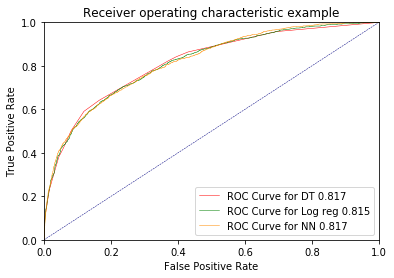

In [32]:
import matplotlib.pyplot as plt

plt.plot(fpr_dt, tpr_dt, label='ROC Curve for DT {:.3f}'.format(roc_index_dt), color='red', lw=0.5)
plt.plot(fpr_log_reg, tpr_log_reg, label='ROC Curve for Log reg {:.3f}'.format(roc_index_log_reg), color='green', lw=0.5)
plt.plot(fpr_nn, tpr_nn, label='ROC Curve for NN {:.3f}'.format(roc_index_nn), color='darkorange', lw=0.5)

# plt.plot(fpr[2], tpr[2], color='darkorange',
#          lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=0.5, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [33]:
# import the model
from sklearn.ensemble import VotingClassifier

# initialise the classifier with 3 different estimators
voting = VotingClassifier(estimators=[('dt', dt_model), ('lr', log_reg_model), ('nn', nn_model)], voting='soft')

In [34]:
# fit the voting classifier to training data
voting.fit(X_train, y_train)

# evaluate train and test accuracy
print("Ensemble train accuracy:", voting.score(X_train, y_train))
print("Ensemble test accuracy:", voting.score(X_test, y_test))

# evaluate ROC auc score
y_pred_proba_ensemble = voting.predict_proba(X_test)
roc_index_ensemble = roc_auc_score(y_test, y_pred_proba_ensemble[:, 1])
print("ROC score of voting classifier:", roc_index_ensemble)

Ensemble train accuracy: 0.817176652096
Ensemble test accuracy: 0.822558872056
ROC score of voting classifier: 0.825728685614
